In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import GroupKFold , KFold

import os

print_line = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print_line += 1
        if print_line < 5:
            print(os.path.join(dirname, filename))
        else:
            pass
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-effectiveness/sample_submission.csv
/kaggle/input/feedback-prize-effectiveness/train.csv
/kaggle/input/feedback-prize-effectiveness/test.csv
/kaggle/input/feedback-prize-effectiveness/test/D72CB1C11673.txt


In [18]:

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if not iskaggle:
    import zipfile,kaggle
    path = Path('feedback-prize-effectiveness')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [19]:
from fastai.imports import *

In [20]:
if iskaggle: path = Path('../input/feedback-prize-effectiveness')
path.ls()

(#5) [Path('../input/feedback-prize-effectiveness/sample_submission.csv'),Path('../input/feedback-prize-effectiveness/train.csv'),Path('../input/feedback-prize-effectiveness/test.csv'),Path('../input/feedback-prize-effectiveness/test'),Path('../input/feedback-prize-effectiveness/train')]

In [9]:
train = pd.read_csv('../input/feedback-prize-effectiveness/train.csv')

In [22]:
test  = pd.read_csv(path/'test.csv')

In [29]:
len(train.discourse_id.unique()) == len(train)

True

In [31]:
train.essay_id.value_counts()

91B1F82B2CF1    23
4CA37D113612    23
900A879708F0    23
A7EC6F462F8B    22
DECAE402BB38    22
                ..
AB02689C1A9B     1
FFFF80B8CC2F     1
377548575048     1
5E85F1FB4E22     1
9706F8E7D534     1
Name: essay_id, Length: 4191, dtype: int64

In [34]:
train.loc[train.essay_id == '91B1F82B2CF1'].head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
25190,2d4def8e7c09,91B1F82B2CF1,Many people may think that attending school online is better than going to school in person. They say that it is better for mental heath and classes can be more advanced or personal for the one student.,Lead,Adequate
25191,0a6634792991,91B1F82B2CF1,"I would say that I disagree with that statement, although on some aspects I do agree.",Position,Adequate
25192,e73c3a854460,91B1F82B2CF1,"Yes, online school would be better for students' mental health now",Counterclaim,Adequate
25193,57d92e1dddb3,91B1F82B2CF1,but what about in the future when they lack basic social skills?,Rebuttal,Adequate
25194,4e57f20c26e0,91B1F82B2CF1,"yes, the online courses could be more personalized to a specific student on some softwares",Counterclaim,Adequate


In [ ]:
for 

In [17]:
train['discourse_text']

0        Hi, i'm Isaac, i'm going to be writing about h...
1        On my perspective, I think that the face is a ...
2        I think that the face is a natural landform be...
3        If life was on Mars, we would know by now. The...
4        People thought that the face was formed by ali...
                               ...                        
36760    For many people they don't like only asking on...
36761    also people have different views and opinions ...
36762    Advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object

In [40]:
essay_len = []
for file in os.listdir(path/'train'):
    with open (path/'train'/file) as f:
        essay_len.append(len(f.read()))

In [41]:
min(essay_len) , np.mean(essay_len) , max(essay_len)

(691, 2315.0465282748746, 11641)

(array([1.789e+03, 1.329e+03, 5.840e+02, 3.030e+02, 1.770e+02, 6.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  691.,  1786.,  2881.,  3976.,  5071.,  6166.,  7261.,  8356.,
         9451., 10546., 11641.]),
 <BarContainer object of 10 artists>)

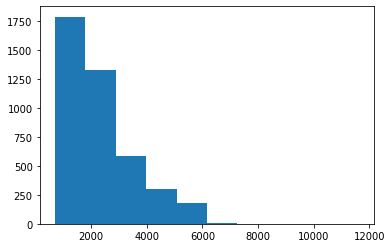

In [42]:
plt.hist(essay_len)

In [46]:
text_len = [len(text) for text in train.discourse_text]

(array([3.0332e+04, 4.9030e+03, 1.1340e+03, 2.7600e+02, 7.6000e+01,
        2.4000e+01, 9.0000e+00, 7.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([4.0000e+00, 4.1350e+02, 8.2300e+02, 1.2325e+03, 1.6420e+03,
        2.0515e+03, 2.4610e+03, 2.8705e+03, 3.2800e+03, 3.6895e+03,
        4.0990e+03]),
 <BarContainer object of 10 artists>)

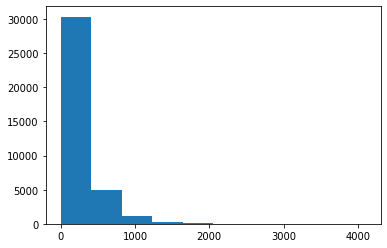

In [48]:
import matplotlib.pyplot as plt
plt.hist(text_len)

In [52]:
train.discourse_type.value_counts()


Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: discourse_type, dtype: int64

In [54]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [55]:
if iskaggle:
    !pip install --no-index --find-links ../input/huggingface-datasets datasets -q
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [56]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)


In [59]:
model_nm = '../input/debertav3small'

In [60]:
tokz = AutoTokenizer.from_pretrained(model_nm)

In [61]:
tokz

PreTrainedTokenizer(name_or_path='../input/debertav3small', vocab_size=128000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
def reduce_mem_usage(df):
    cols = df.columns.tolist()
    
    for col in cols:
        